# Урок 9. Разметка данных

In [1]:
import sys

In [2]:
!jupyter kernelspec list

Available kernels:
  python3    e:\Диски_old\ADATA_MYPROJ\Proj\Study\GeekBrains\C3_05_DataCollection\tasks\L09_LabelData_hw\venv\share\jupyter\kernels\python3
  py319      C:\Users\Vladimir\AppData\Roaming\jupyter\kernels\py319


In [3]:
!chcp 65001

Active code page: 65001


In [4]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import matplotlib

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Задание 1. Загрузка датасета
Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.

In [6]:
df = pd.read_json('data/kinopoisk.jsonl', lines=True)
pd.reset_option('display.max_colwidth', None)

In [7]:
df[df['grade3'] == 'Good'].head(3)

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24,Плакали наши денежки ©,Good,10.0,"\n""Блеф» — одна из моих самых любимых комедий...."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04,None,Good,0.0,\nАдриано Челентано продолжает радовать нас св...
2,top250,Блеф (1976),17137,Flashman,2007-03-04,None,Good,10.0,"\nНесомненно, это один из великих фильмов 80-х..."


In [8]:
df[df['grade3'] == 'Bad'].head(3)

,part,movie_name,review_id,author,date,title,grade3,grade10,content
86,top250,Рапунцель Запутанная история (2010),23842,-Magnet-,2011-01-08,Разбор полётов от Магнета,Bad,0.0,"\nКак же уныло… Я вынужден констатировать, что..."
87,top250,Рапунцель Запутанная история (2010),23839,None,2011-03-13,"Если вы не женского пола, и вам меньше 8 или б...",Bad,1.0,"\nСобственно говоря, ничего экстраординарного ..."
100,top250,Рапунцель Запутанная история (2010),23833,WerewolfMoon,2011-10-08,Это уже не Дисней,Bad,0.0,"\nКлассика Уолта Диснея — вот те мультфильмы, ..."


## Задание 2. Разметка на основе правил
Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.

Определение набора положительных и отрицательных слов

In [9]:
# pd.reset_option('display.max_colwidth', None)
# pd.reset_option('display.max_columns', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [10]:
df[df['grade3'] == 'Bad']['content'].head(3)
None

In [11]:
negative_words = [
    "уныло", "унылый", "унылая"
    "чёрный список",
    "претензии", "претензия"
    "тупой", "тупая", "тупые",
    "банальный", "банальная", "банальное", "банальные",
    "абсурд", "абсурда", "абсурду"
    "жуть", "жути",
    "ненавижу", "ненавидеть",
    "смотреть отказался",
    "тупой и глупый",
    "глупость",
    "сомнительный", "сомнтиельными", "сомнитальная",
    "непедагогичен",
    "дура", "дуре", "дуру",
    "некрасивый", "некрасивые", "некрасивая",
    "ничего привлекательного",
    "плохой", "плохая", "плохие", "плохое"
]

In [12]:
df[df['grade3'] == 'Good']['content'].head(3)
None

In [13]:
positive_words = [
    "любимый", "любимая", "любимое", "любимый",
    "восхоищение", "восхищения", "восхищением",
    "великолепный", "великолепная", "великолепное", "великолепные", "великолепно",
    "браво", "брависимо",
    "рекомендую", "рекомендовать",
    "радовать", "радует", "радостно",
    "захватывающий", "захватывающая", "захватывающее", "захватывающие", "захватывающе",
    "интересный", "интересная", "интересное", "интересные", "интересно",
    "оригинальный", "оригинальная", "оригинальное", "оригинальные", "оригинально", "оригинальность"
    "удовольствие", "удовольствием", "удовольствия",
    "блестящий", "блестящая", "блестящие", "блестяще",
    "наслаждение", "наслаждения", "наслаждением",
    "потрясающий", "потрясающая", "потрясающие", "потрясающе",
    "добрый", "добрая", "доброе", "добрые",
    "продуманный", "продуманная", "продуманное", "продуманные",
    "похвала", "похвале", "похвалы",
    "расслабиться", "расслабляет",
    "отдохнуть",
    "исключительный", "исключительная", "исключительное", "исключительные", "исключительно",
    "один из лучших", "одна из лучших", "одни из лучших",
    "великий", "великая", "великое", "великие",
    "достойный", "достойная", "достойное", "достойные", "достойно",
]

Функция для присвоения метки настроения на основе наличия положительных или отрицательных слов:

In [14]:
def get_sentiment(text):
    # Токенизация текста на отдельные слова
    words = nltk.word_tokenize(text.lower())
    # Подсчет количества положительных и отрицательных слов
    num_positive = sum([1 for word in words if word in positive_words])
    num_negative = sum([1 for word in words if word in negative_words])
    # Присвоение метки на основе чистой оценки настроения
    if num_positive > num_negative:
        return 'positive'
    elif num_negative > num_positive:
        return 'negative'
    else:
        return 'neutral'

Тестирование функции на негативном контенте:

In [15]:
print(get_sentiment(
    '''
    Как же уныло… Я вынужден констатировать, что славная студия Дисней утратила моё доверие и попала в чёрный список студий, новые мультфильмы которых теперь я смотреть не буду. Признаться, в списке до этого были лишь ДримВоркс, но если учесть, что для меня в анимации существует только три крупных рыбы — Дисней, ДримВоркс и Пиксар, то надежда остаётся только на последних. Те, слава Богу, в последние годы делают исключительно шедевры или близко к ним, так что можно не беспокоиться. \n\nБлиже к «Рапунцель». Во время просмотра у меня постоянно копились новые претензии, которые я впоследствии забывал по причине их обильности. Поэтому я пойду проверенной схемой, поочередно обозвав плохими словами сюжет, юмор и персонажей. Начнём.\n\nI. Сюжет.\n\nГерои движутся из точки А в точку Б, попутно зарабатывая приключения на свою пятую точку. У меня сразу возникает дежавю, потому что тоже самое я писал в своём отзыве на «Ледниковый период». Ну мультфильмов с такой концепцией — миллионы. Другое дело, что я такие мультики не люблю. Единственный плюс, который я нашёл — нет говорящих животных. Ну и обязательная любовная линия. Как же без этого. Всё по законам тупых, банальных фильмов. Про это писать не буду, ибо и так понятно.\n\nЧем заканчивается мультик, понятно тоже. Вроде бы неожиданные сюжетные твисты порой оборачиваются таким абсурдом…\n\nPS. В одной рецензии прочитал, что сюжет в мультфильме гениальный. Жуть.\n\nII. Персонажи.\n\nС ними вообще беда. Главный мужик (тот, что вор) карикатурен до жути — самодовольный, конечно, красавчик, но внутри он лапочка. Рапунцель — тоже красотка, как и подобает, и характер замечательный — сказка же, поэтому хорошие персонажи должны быть просто феноменально хорошими. Конь напоминает осла из Шрека, только лучше — молчит всё время. Стражники, естественно, тупые, а мачеха умная, но очень злая. Штамп на штампе, поэтому и скучно. \n\nIII. Юмор.\n\nА вот и самая в пух и прах разносимая мною категория. Приступаю к разгрому со зловещим смехом.\n\nОдна из главных проблем современных мультфильмов — это то, что их всех шлифуют под целевую аудиторию, то есть под детсад и началку. Ни одной более менее нормальной шутки я вспомнить не могу, потому что весь юмор заключается в ударах сковородкой по голове и тому подобные вещи. Я искренне не понимаю, почему это так смешно. Мультипликаторам давно пора прекратить вставлять такие вещи в мультфильмы, ведь это развивает жестокость в детях! Сейчас под понятием «кино для всей семьи» понимаются комедии вроде «Один дома» с пытками, в прямом смысле слова. Я уверен, что боссы студий это прекрасно понимают, но им нужны лишь деньги. По-настоящему добрые мультфильмы не начнут делать до тех пор, пока есть спрос на такие поделки. Очевидно, что спрос на такую продукцию будет всегда, поэтому ничего поделать уже нельзя. Я расстроен. Мне противно слышать, как после ударов по голове чугунной сковородой зал взрывается от детского смеха.\n\nЗаканчиваю разгром с грустными мыслями. Я ненавижу мультфильм «Том и Джерри».\n\nБонус:\n\nIV. Мъюзикальная составляющая.\n\nМне абсолютно наплевать, какое качество у песен, а всё потому, что я не переношу этот жанр. Помню, как в своей рецензии на «Король лев» я ругал Дисней за лишнюю трату экранного времени. А ругать жанр следует не только за это. Вот представьте ситуацию: заходите вы в автобус, передаёте деньги за проезд, после чего кондуктор нараспев говорит «Спасибо»; вы, также напевая, отвечаете «Пожалуйста», и все пассажиры начинают танцевать и петь. Абсурд? Абсурд. Поэтому я и не люблю мюзиклы. \n\nНу а для любителей — песни вроде хорошие, качественные. Правда, весь смысл, наверное, теряется при переводе, так что при возможности смотрите в оригинале с субтитрами.\n\nВот и всё. Если можно, подведу итоги года. \n\nИстория игрушек 3 — 9,5 из 10.\n\nЛегенды ночных стражей — 5,5 из 10.\n\nКак приручить дракона — 4 из 10.\n\nЗапутанная история — 4 из 10\n\nПиксар, как обычно, лучшие, а Дисней — неожиданно также плохи, как и Дримы. \n\nНе ходите на этот мультик.
    '''
))

negative


In [16]:
print(get_sentiment(
    '''
    Собственно говоря, ничего экстраординарного от этой анимации я не ожидал, приобрёл её исключительно для того, чтобы было что показать 5-летнему племяннику, наезжающему иногда в гости. Тем более что Шрэков и Как приручить дракона он уже посмотрел немеряное количество раз. \n\nВпрочем, после пяти минут просмотра он дальше смотреть отказался. Тогда мы с сестрой решили посмотреть фильм сами, мало ли что, всё-таки после Как приручить дракона моё мнение о голливудских детских анимационных фильмах сильно улучшилось. В итоге мы с ней сошлись во мнении, что чутьё племянника не подвело. Фильм действительно тупой и глупый. Впрочем, по порядку.\n\n1. Сценарий. \n\nСценарий фильма не просто не проработан, он абсурден в деталях и непедагогичен в целом. Великовозрастная дура, которая до 18 лет сидит в башне, запуганная опасностями внешней жизни, отнюдь не вызывает умиления. Попавший к ней в башню вор с намёками на комплексы первые минут пять после своего появления выглядит получше, но потом, вероятно, также заразившись тяжёлой формой кретинизма (чего только в сказках не бывает) начинает по воле сценариста совершать поступки ещё глупее своей подруги. Изображающая мать главной героини ведьма, которая на самом деле похитила её — просто сбывшаяся мечта девочки-подростка, считающей свою мать ведьмой, в то время как на самом деле она дочь королевны. \n\n2. Музыка.\n\nКлассические напевы ни о чём. Ну ладно, ожидать осмысленных текстов с учётом того, что даже над сценарием не заморочились, было бы глупо. Ей богу, лучше бы их просто не переводили, не так явственно вскрывалась бы убогость содержания. Но уж музыку-то хотя бы можно было нормальную заказать? Не знаю, может быть в связи с кризисом, но из штук 15 песенок, которые жутко раздражают глупыми текстами, после просмотра невозможно вспомнить практически ни одной. \n\n3. Анимация.\n\nНу тут и говорить нечего, всё понятно уже по постеру. Барби и Кен во всей своей красоте, только у Барби сильно прогрессирующая базедова болезнь, в результате которой глаза занимают практически поллица. \n\n4. Собаки.\n\nПо аналогии с «Влюблённым Шекспиром», где Елизавете приписывалась страсть к любовным сценам и собакам в театральных постановках, я решил так озаглавить раздел о единственном позитивном моменте этого фильма. В качестве комедийных составляющих присутствуют хамелеон, конь и парочка разбойников. Вот они действительно хороши. Впрочем, сцены с их участием тянут примерно на 10% экранного времени, так что вряд ли оправдывают просмотр всего остального.\n\nИтого:\n\nГлавной загадкой для меня, как и для сестры, впрочем, стало то, для кого всё это снималось. В результате обсуждения мы пришли к выводу, что единственная аудитория, которая не заметит всю глупость этой картины ради любви Барби и Кена и оправдания неуважения к матери её сомнительными правами могут быть только девочки в возрасте от 8 до 14 лет. До восьми тема любви не так актуальна, да и с матерями ещё всё более менее ничего, а после 15 у нормальных девочек обычно формируется критическое мышление. Мальчикам же тут ловить нечего по определению — в нашем гендерно неравноправном обществе мечтать о богатой жене-принцессе мальчики начинают довольно поздно, когда такие глупые фильмы уже не проходят. Да и к любви эти мечты не имеют никакого отношения.\n\nТаким образом, поскольку я не девочка и мне в любом случае больше 15 лет ставлю\n\n1 из 10 \n\n(соответственно доле собачек в фильме)
    '''
))

negative


In [17]:
print(get_sentiment(
    '''
    Классика Уолта Диснея — вот те мультфильмы, которые действительно можно считать продуктами этой студии. Все остальное делается лишь для того, чтобы нажиться и заработать кучу денег. Увы, но это так.\n\nВо-первых, где вы видели, чтобы диснеевские принцессы (не будем забывать, кто такая Рапунцель на самом деле) были такими… воинственными (?) и, вооружившись сковородкой а-ля орудием свободы пошли молотить плохих ребят? Я уже не говорю, что Рапунцель сделала с бедным юношей в башне… Откуда столько агрессии и самоуверенности? Во-вторых, графика. Не спорю, анимация хороша, но уважаемые создатели, это же Дисней! Знаете, что такое рисованные мультфильмы? Вот и работайте в этом направлении, пересмотрите классику, что ли. Потому что красивая графика не мешает увидеть, что сами по себе персонажи яркие, но абсолютно некрасивые. Да-да, я не вижу ни в Рапунцель, ни а ее мачомене Флинне ничего привлекательного. Да и сами персонажи шаблонны. Рапунцель напоминает Фиону из Шрека, ей бы волосы укоротить и покрасить и еще боевыми искусствами овладеть — хоп — вот вам Фиона. А Флинн… ну как Шрек почти. Сначала не понимает, на кой черт ему все это нужно, а потом бац — влюбляется в принцессу. А теперь конь. Многие видят в нем осла из Шрека, а мне он больше напоминает коня из «Мулан» Хана или коня Филиппа из «Спящей красавицы». Только если там жеребцы были просто смышлеными, то конь из «Рапунцель» просто венец супергероя. \n\nИзвините, но я не знаю, чему может научить этот мультик и где там вообще добро. Постоянные драки и преследования, тема любви и финальный, почти трагичный конец.
    '''
))

negative


Тестирование функции на позитивном контенте:

In [18]:
print(get_sentiment(
    '''
    Блеф» — одна из моих самых любимых комедий.\n\nЭтот фильм я наверно смотрел раз сто, нет я конечно блефую, я видел его куда больше. Не могу не выразить своё восхищение главными действующими лицами этого фильма. Начну с Адриано Челентано для которого как я считаю это лучшая роль в кино. Великолепный актёр, неплохой певец, странно что на его родине в Италии его песни мало кто слушает. Ну я думаю что и итальянцы и французы привыкли к тому, что у нас до сих их актёры популярней чем даже на своей родине. Да, такой вот парадокс. Челентано конечно профессионал своего дела, комик с серьёзным выражением лица. Он смешон ещё и потому, что одновременно так серъёзен. Адриано браво!\n\nА теперь несколько слов об Энтони Куине. Да тот самый горбун из Нотр-дама. Собор Парижской Богоматери, оригинальная версия, кто не смотрел рекомендую. С ним как-то приключилась одна интересная история. На съёмках одного из своих фильмов он то ли сломал, то ли подвихнул ногу, а роль требовала от него чтобы в одной из сцен он кружился с дамой в танце. И он вместе со съёмочным коллективом вышел из этого положения. Они сделали вращающеюся платформу, которая создавала видимость того, что он весь в ритме танца. Вот такая вот история, к слову об этом замечательном актёре.\n\nНу и теперь сам фильм, жанр которой можно смело обозвать авантюрой. Комедийной авантюрой. Некая Белль Дьюк, весьма влиятельная дама, пытается освободить своего старого знакомого авантюриста Филиппа Бенга, у которого с ней давние счёты. Но вместо него на свободе оказывается другой комбинатор-аферист по имени Феликс. И чтобы не быть битым головорезами Белль Дьюк, он уже сам разрабатывает план побега Бэнга. После того как они встречаются череда смешных сцен заставит зрителя разразиться шквальным смехом. В их умений блефовать, им просто нет равных. Главное правило чтобы блеф сработал, надо самому в него поверить. Помимо всего этого они ещё и соревнуются в стратегий блефа. Некоторые сцены их обмана запомнились мне надолго, особенно сцена в магазине тканей: \n\n — Привет старина. Так тебя выпустили из лепрозория?\n — Не совсем, я оттуда сбежал.\n\nНу или финальная сцена, которую можно охарактеризовать тремя словами; смех сквозь слёзы.\n\nВ завершении скажу, что это великолепное кино можно смотреть и пересматривать очень много раз, и оно не потеряет своего шарма и обаяния.\n\n10 из 10
    '''
))

positive


In [19]:
print(get_sentiment(
    '''
    Адриано Челентано продолжает радовать нас своими работами в жизни кино и в сфере музыкального творчества. Новая захватывающая, интересная и талантливо исполненная история покажет, какие бывают денежные махинации в мире, чего стоит связаться с оригинальным, находчивым человеком, которого зовут Феникс, как заполучить приличную денежную сумму, чтобы жить всю оставшуюся жизнь в роскоши и в свое удовольствие.\n\nБлестяще смешной фильм, рассчитанный на широкую аудиторию, комедия, от которой получаешь наслаждение, где проникаешься игрой актеров и чувствуешь их азартный вкус на вещи, когда хочется лечь на кровать, не думать ни о чем, а лишь наблюдать за игрой потрясающих актеров, со временем только выросшем в профессиональном аспекте.\n\nДа, добрая, немного наивная картина, не скучная, со вкусом, с оригинальными, хорошо продуманными моментами, некоторые эпизоды заслуживают отдельной похвалы, потому что здесь блещет оригинальность создателей.\n\nНе стоит думать о плохом, хотите расслабиться после работы, мой совет — посмотрите «Блеф», это все, что вам нужно, настроение точно поднимется.
    '''
))

positive


In [20]:
print(get_sentiment(
    '''
    Несомненно, это один из великих фильмов 80-х годов. Исключительная комедия с великолепными исполнителями! Челентано и Куинн один из лучших дуэтов в жанре комедии. Этот фильм можно посмотреть один раз, а можно сто, это не важно эффект будет один и тот же. Смех, смех и еще раз смех, каждую минуту этого фильма.\n\nВеликая классика, достойна отличной оценки.\n\n10 из 10
    '''
))

positive


Функция для получения полярности настроения:

In [39]:
df_rbl = df.sample(1000)

In [40]:
df_rbl['sentiment'] = df_rbl['content'].apply(get_sentiment)

In [41]:
df_rbl[df_rbl.columns.drop('content')].sample(3)

,part,movie_name,review_id,author,date,title,grade3,grade10,sentiment
6903,top250,Легенда о пианисте (1998),16149,digitaltheater,2012-01-19,Смысл вот в чем…,Good,0.0,neutral
33394,bottom100,Темный мир в 3D (2010),25663,Лекс Картер,2010-10-11,«Бедный ребенок! Бардак в голове»,Bad,0.0,positive
6414,top250,В погоне за счастьем (2006),13558,Дмитрий Алейников,2009-01-27,None,Bad,0.0,positive


## Задание 3. Разметка в Label Studio
Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.

In [42]:
df_lbl = df.sample(1000)

In [43]:
def f1(grade):
    if grade == 'Good':
        return 'positive'
    elif grade == 'Bad':
        return 'negative'
    else:
        return 'neutral'

df_lbl['sentiment'] = df_lbl['grade3'].apply(f1)

In [44]:
df_lbl['sentiment'].value_counts()

sentiment
positive    734
neutral     136
negative    130
Name: count, dtype: int64

## Задание 4. Объединение наборов данных
Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.

In [45]:
df_all = pd.concat([df_rbl, df_lbl])
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 12619 to 18695
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   part        2000 non-null   object        
 1   movie_name  2000 non-null   object        
 2   review_id   2000 non-null   int64         
 3   author      1957 non-null   object        
 4   date        2000 non-null   datetime64[ns]
 5   title       1521 non-null   object        
 6   grade3      2000 non-null   object        
 7   grade10     2000 non-null   float64       
 8   content     2000 non-null   object        
 9   sentiment   2000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 171.9+ KB


In [48]:
df_all[df_all.columns.drop('content')].sample(3)

,part,movie_name,review_id,author,date,title,grade3,grade10,sentiment
34422,bottom100,Вампирский засос (2010),25273,Just Polina,2010-12-08,Американский юмор.,Bad,2.0,positive
1360,top250,ВАЛЛ·И (2008),7539,Эл Брегг,2008-07-08,"«Смотрите, он как настоящий! »",Good,9.0,positive
27196,top250,Рататуй (2007),25497,iron_man-04,2010-01-31,«Крыса — повар»,Good,0.0,positive


## Задание 5. Обучение модели машинного обучения
Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.

In [137]:
pd.reset_option('display.max_colwidth')

In [138]:
movies = df_all[['content', 'sentiment']].rename(columns={'content': 'text', 'sentiment': 'label'})

Преобразование в 'sentiment':
- 'neutral' на 0:
- 'negative' на 1:
- 'positive' на 2

In [139]:
def f2(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'negative':
        return 1
    else:
        return 0

movies['label'] = movies['label'].apply(f2)

In [140]:
movies.head(3)

,text,label
12619,"\nПосмотрела, наконец, Хатико. В осадке. Хотя ...",1
31640,\n Живёт себе да поживает один режиссёр. ...,0
17815,"\nВеликолепный, юморной, искрометный фильм. Бе...",2


Распределение отзывов в объединённом датасете:

<Axes: >

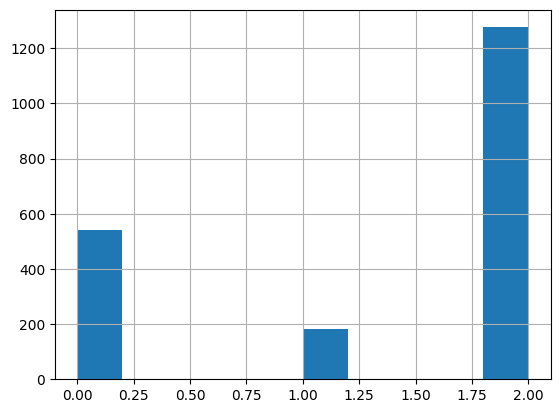

In [141]:
movies['label'].hist()

Перемешивание данных.  
Разделение датасета на размеченную и неразмеченную выборки:

In [142]:
movies = shuffle(movies)
labeled_marks, unlabeled_marks = train_test_split(movies, train_size=0.8, random_state=34)

In [143]:
labeled_marks.head(3)

,text,label
31647,\n Посмотрела я «Обитаемый остров» и в об...,2
17311,\nВсегда настороженно отношусь к признанным пу...,2
18902,"\n«Помните нас, ибо мы тоже жили, любили и сме...",0


In [144]:
unlabeled_marks.head(3)

,text,label
16636,\nЯ обожаю этот фильм. Я уже сбилась со счета ...,0
24528,\nНо эта история оставила меня равнодушной. Ав...,1
28124,"\nЭтот фильм нечто большее, чем просто хорошее...",2


In [145]:
labeled_marks.info(), unlabeled_marks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 31647 to 14795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1600 non-null   object
 1   label   1600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 16636 to 22847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
 1   label   400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


(None, None)

Функция для обучения модели логистической регрессии на размеченных данных:

In [146]:
def train_model(labeled_data):
    # Векторизация текстовых данных с помощью TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_data['text'])
    y = labeled_data['label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

model, vect = train_model(labeled_marks)  # model - обученная модель на входных данных X и эталонных решениях y
                                          # vect - вектор частот встречющихся слов в текстах, полученных из тестовой выборки

## Задание 6. Оценка  эффективности обученной модeли
Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.

Прогнозирование настроения неразмеченных данных, используя обученную модель:

In [148]:
X_unlabeled = vect.transform(unlabeled_marks['text'])
y_unlabeled_predicted = model.predict(X_unlabeled)

"Обратное" предсказание слов в векторе частот, полученных из тестового, объединённого с обучающим набором данных.  
Вычисление неопределённости попадания предсказанных слов в их тексты:  
т.е. насколько правильно то, что данное слово присутствует в данном тексте с данной частотой.  

Неопределённость (энтропия) определяется на множестве вероятностей встречаемости каждого слова:  
__y_unlabeled_proba__ - (_'proba'_ - от _'probability'_) массиввероятностей для каждого слова, имеющегося в векторе.

Результат - неопределённость:  
__uncertanty__ - массив неопределённостей (энтропия - случайность) для каждого слова, имющегося в векторе.  

Чем ___выше___ неопределённость (случайность, энтропия) для данного слова, тем предсказание боле  точное.

In [149]:
y_unlabeled_proba = model.predict_proba(X_unlabeled)                         # Вероятности встречаемости слов
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)  # Неопределённость встречаемости слов

In [150]:
y_unlabeled_proba  # Вероятности

array([[0.24149468, 0.06925593, 0.68924939],
       [0.31767109, 0.13285846, 0.54947045],
       [0.17620018, 0.04595259, 0.77784723],
       ...,
       [0.16228397, 0.04620978, 0.79150626],
       [0.30109701, 0.15405228, 0.54485071],
       [0.22563936, 0.04919842, 0.72516222]])

In [151]:
uncertainty  # Неопределённости

array([1.13187638, 1.38712207, 0.92745474, 1.34302531, 1.23322123,
       1.26823562, 1.08081856, 1.17038596, 1.06977514, 1.4256127 ,
       0.98777645, 1.08690323, 1.26962154, 1.25019552, 1.27787114,
       0.70686632, 1.07263879, 0.89864664, 1.17739771, 1.31886028,
       1.15665788, 1.15233998, 1.28607094, 0.83129127, 1.29098041,
       0.99536942, 1.23361174, 1.08171294, 0.85651633, 0.85265727,
       0.87357813, 1.26977956, 1.32876345, 1.25361929, 1.21929959,
       1.31913547, 1.28026168, 1.22197283, 1.21998088, 0.96019523,
       0.78884606, 1.03437184, 1.234154  , 1.16127284, 0.99884078,
       1.31248318, 1.26012788, 1.14905744, 0.75941812, 1.21052734,
       1.08594552, 1.04564951, 1.09567349, 0.83590092, 0.9135848 ,
       1.10327612, 1.43518079, 0.96121171, 1.0312266 , 1.07971269,
       1.35078726, 1.32468562, 1.37261866, 0.95687322, 0.99916145,
       1.19035791, 1.01227726, 1.20261762, 1.13815501, 1.29137873,
       1.01574556, 1.33901247, 1.22405471, 1.24047781, 1.43648

Отбор наименее точных предсказаний (с более высокой энтропией) для ручной разметки.

In [152]:
labeled_marks_new = unlabeled_marks.iloc[uncertainty.argsort()[:100]]     # Первые 100 - самые неточные предсказания, которые необходимо разметить вручную
unlabeled_marks_correction = unlabeled_marks.iloc[uncertainty.argsort()[100:]]   # Оставшиеся предсказания:
                                                                          # новый набор тестовых данных,
                                                                          # которые будут приниматься на входе для проверки через предсказания

In [153]:
labeled_marks_new

,text,label
11386,"\nФильм «Малышка на Миллион», снятый моим люби...",2
28294,"\nВесь мир — театр, а люди в нем — актеры\n\n«...",0
25169,"\nЭто был первый фильм Мартина Скорсезе, котор...",2
25129,"\nНесмотря на то, что данный фильм является бе...",2
11731,\nЛучший друг молодого человека — это его мама...,2
...,...,...
4496,"\n«О, шшит», — ругнулся мой киноманский мозг г...",0
29391,\n«Внутри себя я танцую». Увидев подобное назв...,2
15026,\n«Дневник памяти». Поздно он до меня дошел. Я...,2
22847,\n«Престиж» — явная заявка Нолана на серьезные...,2


Выполнена повторная ручная разметка (корректировка) текстов с самыми неточными предсказаниями,  
которые указывают на то, что автоматический прогноз настроения был ошибочен.  

Откорректированный набор загружается в ту же переменную `labeled_new`.

Получен новый набор данных, размеченный вручную, который объединяется с исходным размеченным набором, полученным на входе в модель обучения.  
Объединяем наборы данных, размеченные вручную, так, что теперь входные данные включают критические тексты, по которым были уточнены (откорректированы) настроения, которые модель предсказала хуже всего.

In [154]:
labeled_marks_correction = pd.concat([labeled_marks, labeled_marks_new])

In [155]:
labeled_marks_correction.info(), labeled_marks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1700 entries, 31647 to 16358
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1700 non-null   object
 1   label   1700 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 31647 to 14795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1600 non-null   object
 1   label   1600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.5+ KB


(None, None)

In [156]:
unlabeled_marks_correction.info(), unlabeled_marks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 13735 to 34997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    300 non-null    object
 1   label   300 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 16636 to 22847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
 1   label   400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


(None, None)

Переобучение модели на расширенном размеченным множестве:

In [160]:
model, vect = train_model(labeled_marks_correction)

В качестве тестовых данных для проверки модели возьмём данные из оставшегося набора `unlabled_marks_correction`:

In [161]:
marks_test = unlabeled_marks_correction

In [162]:
X_test = vect.transform(marks_test['text'])
y_test_predicted = model.predict(X_test)

In [165]:
marks_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 13735 to 34997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    300 non-null    object
 1   label   300 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


Оценка качества для цели многоклассовой классификации:
- по метрике __accuracy__

In [169]:
acc = accuracy_score(marks_test['label'], y_test_predicted)
acc

0.5733333333333334

## Вывод
По оценке accuracy=0,57 можно судить, что модель обучена недостаточно. Возможные причины:
- по модели:  
  высокий уровень несбалансированности признаков;  
  метрика accuracy недостаточно точная для данной задачи классификации.
- по контексту:  
  рецензии на фильмы плохо классифицируются по настроениям в силу специфики контекста.  

Вероятность неточного предсказания настроений, как они оценены субъективно или экспертом, достаточно велика.  
Возможные дополнительные улучшения модели:
- применить one-hot encoding для бинарной классификации признаков;
- применить f1 метрику качества к бинарным признакам.